In [3]:
# import the required libraries:
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
import sentencepiece as spm
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import numpy as np
import pickle
import matplotlib.pyplot as plt


In [5]:
#Execute this script to set values for different parameters:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES = 256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
# 300 = dimension of the GloVe word embeddings
EMBEDDING_SIZE = 300

The language translation model that we are going to develop will translate English sentences into their French language counterparts. To develop such a model, we need a dataset that contains English sentences and their French translations.

# Data Preprocessing

We need to generate two copies of the translated sentence: one with the start-of-sentence token and the other with the end-of-sentence token.



In [6]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open('fra.txt', encoding="utf-8"):
    count += 1
    if count > NUM_SENTENCES:
        break
    if '\t' not in line:
        continue
    input_sentence = line.rstrip().split('\t')[0]
    output = line.rstrip().split('\t')[1]

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Number of sample input:", len(input_sentences))
print("Number of sample output:", len(output_sentences))
print("Number of sample output input:", len(output_sentences_inputs))

Number of sample input: 20000
Number of sample output: 20000
Number of sample output input: 20000


Now randomly print a sentence to analyse your dataset.

In [7]:
print("English sentence: ",input_sentences[180])
print("French translation: ",output_sentences[180])

English sentence:  Be fair.
French translation:  Soyez honnêtes. <eos>


# Tokenization and Padding


The next step is tokenizing the original and translated sentences and applying padding to the sentences that are longer or shorter than a certain length, which in case of inputs will be the length of the longest input sentence. And for the output this will be the length of the longest sentence in the output.

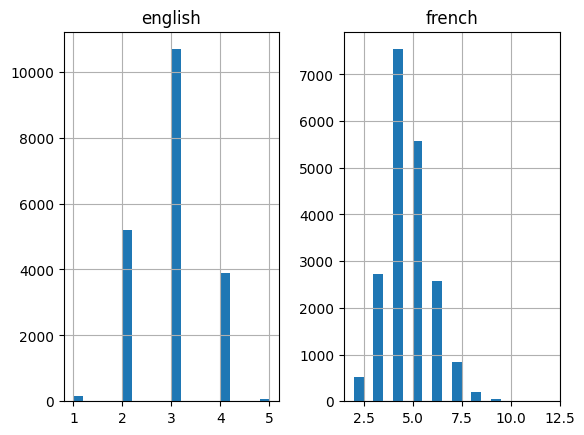

298145
513364
513364


In [10]:
# let’s visualise the length of the sentences.
import pandas as pd

eng_len = []
fren_len = []

# populate the lists with sentence lengths
for i in input_sentences:
      eng_len.append(len(i.split()))

for i in output_sentences:
      fren_len.append(len(i.split()))

length_df = pd.DataFrame({'english':eng_len, 'french':fren_len})

length_df.hist(bins = 20)
plt.show()

all_input_sentences = '\n'.join(input_sentences)
all_output_sentences = '\n'.join(output_sentences)
all_output_sentences_inputs = '\n'.join(output_sentences_inputs)
print(len(all_input_sentences))
print(len(all_output_sentences))
print(len(all_output_sentences_inputs))

## SentencePeice Tokenizer
Set up the tokenizer here in a similar fashion to how it will be set up in the final LSTM version. Attempting to use BPE.




In [9]:
#Change this name!
name = 'fra'
class Tokenizer:
    
        def __init__(self, filepath=name+'_tokenizer.model'):
            self.sp = spm.SentencePieceProcessor(model_file=filepath)

        def encode(self, text, t=int):
            return self.sp.encode(text, out_type=t)

        def decode(self, pieces):
            return self.sp.decode(pieces)
        #Some of these paramters may be changed. 
        def train(iterable_data, model_prefix='sp_model', vocab_size=MAX_NUM_WORDS):
            spm.SentencePieceTrainer.train(input=iterable_data, model_prefix=model_prefix, vocab_size=vocab_size,
                                           input_sentence_size=MAX_SENTENCE_LENGTH, shuffle_input_sentence=True)



298145
513364
513364


## Keras Model tokenizer


In [17]:
#tokenize the input sentences(input language)
input_tokenizer = tokenizer.encode(input_sentences, MAX_NUM_WORDS)

input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
print(input_integer_seq)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)



ValueError: Tokenizer model has not been loaded.

In [7]:
#tokenize the output sentences(Output language)
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
print(output_input_integer_seq)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)



[[2, 45, 4], [2, 542], [2, 24, 449, 4], [2, 419, 4], [2, 1461, 4], [2, 2658], [2, 2659], [2, 2660], [2, 113, 239, 1179, 21, 239, 1920, 4], [2, 1462, 4], [2, 1921, 4], [2, 668, 4], [2, 2661, 4], [2, 2662, 4], [2, 2659], [2, 2660], [2, 113, 239, 1179, 21, 239, 1920, 4], [2, 1462, 4], [2, 1921, 4], [2, 668, 4], [2, 2661, 4], [2, 2662, 4], [2, 32, 6], [2, 27, 4466], [2, 4467], [2, 4468], [2, 21, 4469], [2, 4470], [2, 4471], [2, 65, 752, 4], [2, 21, 2663], [2, 4472], [2, 4473], [2, 1922], [2, 1922], [2, 27, 2664], [2, 4474], [2, 1463, 4], [2, 299, 4], [2, 354, 4], [2, 1180], [2, 299, 4], [2, 354, 4], [2, 2665], [2, 1180], [2, 1923], [2, 1924], [2, 4475], [2, 4476], [2, 4477], [2, 1464, 4], [2, 1461, 4], [2, 1464, 4], [2, 1461, 4], [2, 669], [2, 2658], [2, 3, 1465], [2, 4478], [2, 2666], [2, 17, 383, 4], [2, 3, 75, 1008, 4], [2, 126, 340], [2, 4479, 505, 4], [2, 1181], [2, 1925], [2, 1926], [2, 2667, 2668], [2, 2669, 2670], [2, 44, 1466], [2, 1927, 4], [2, 1182, 4], [2, 2671], [2, 1183, 4], 

Now the lengths of longest sentence can also be varified from the histogram above. And it can be concluded that English sentences are normally shorter and contain a smaller number of words on average, compared to the translated French sentences.

Next, we need to pad the input. The reason behind padding the input and the output is that text sentences can be of varying length, however LSTM expects input instances with the same length. Therefore, we need to convert our sentences into fixed-length vectors. One way to do this is via padding.

In [8]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[180]:", encoder_input_sequences[180])

encoder_input_sequences.shape: (20000, 5)
encoder_input_sequences[180]: [  0   0   0  22 313]


Since there are 20,000 sentences in the input and each input sentence is of length 6, the shape of the input is now (20000, 6).

You may recall that the original sentence at index 180 is **join us**. The tokenizer divided the sentence into two words ***join*** and ***us***, converted them to integers, and then applied pre-padding by adding four zeros at the start of the corresponding integer sequence for the sentence at index 180 of the input list.

To verify that the integer values for ***join*** and ***us*** are 464 and 59 respectively, you can pass the words to the word2index_inputs dictionary, as shown below:

In [9]:
print(word2idx_inputs["join"])
print(word2idx_inputs["us"])

459
57


In the same way, the decoder outputs and the decoder inputs are padded.



In [10]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[180]:", decoder_input_sequences[180])

decoder_input_sequences.shape: (20000, 12)
decoder_input_sequences[180]: [   2   52 1939    0    0    0    0    0    0    0    0    0]


The sentence at index 180 of the decoder input is <sos> Joignez-vous à nous. If you print the corresponding integers from the word2idx_outputs dictionary, you should see 2, 2028, 20, and 228 printed on the console.

In [11]:
print(word2idx_outputs["<sos>"])
print(word2idx_outputs["joignez-vous"])
print(word2idx_outputs["à"])
print(word2idx_outputs["nous."])

2
2702
21
230


In [12]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)


decoder_output_sequences.shape: (20000, 12)


# Word Embeddings


We already converted our words into integers. So what's the difference between integer representation and word embeddings?

There are two main differences between single integer representation and word embeddings. With integer reprensentation, a word is represented only with a single integer. With vector representation a word is represented by a vector of 50, 100, 200, or whatever dimensions you like. Hence, word embeddings capture a lot more information about words. Secondly, the single-integer representation doesn't capture the relationships between different words. On the contrary, word embeddings retain relationships between the words. You can either use custom word embeddings or you can use pretrained word embeddings.

For English sentences, i.e. the inputs, we will use the GloVe word embeddings. For the translated French sentences in the output, we will use custom word embeddings.

Let's create word embeddings for the inputs first. To do so, we need to load the GloVe word vectors into memory. We will then create a dictionary where words are the keys and the corresponding vectors are values,

In [13]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'./drive/My Drive/data/glove.twitter.27B.25d.txt', encoding="utf8")

for line in glove_file:
    rec = line.split()
    word = rec[0]
    vector_dimensions = asarray(rec[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

Recall that we have 2150 unique words in the input. We will create a matrix where the row number will represent the integer value for the word and the columns will correspond to the dimensions of the word. This matrix will contain the word embeddings for the words in our input sentences.



In [14]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        if embedding_vector.shape[0] != EMBEDDING_SIZE:
            print(f"Warning: The dimension of the embedding vector for word '{word}' does not match the expected size of {EMBEDDING_SIZE}.")
            continue
        embedding_matrix[word2idx_inputs[word]] = embedding_vector

In [15]:
print(embeddings_dictionary["toast"])

[-0.38356   0.34616  -0.088374  0.96081  -0.60564   0.52596   1.25
 -2.3318   -0.33265   0.17812   1.0174   -0.43354  -2.4718   -1.1475
  0.19073  -0.42697   1.1606   -0.96156  -0.56778   0.53991  -0.62861
  0.81268  -0.22481   0.53014   1.4948  ]


In the previous section, we saw that the integer representation for the word **join** is 464. Let's now check the 464th index of the word embedding matrix.



In [16]:
print(embedding_matrix[464])

[-0.58995998  0.37125     0.62800002 -0.035436   -0.24737    -0.005185
  1.5158      0.19171999 -0.57576001 -0.27336001 -0.28942999  1.005
 -3.3369      0.62295997 -0.64607     0.35411999 -0.11736     0.16034
  0.30408999 -0.44488999  0.10492     0.32025    -0.15999    -0.2192
  0.69344997]


You can see that the values for the 464th row in the embedding matrix are similar to the vector representation of the word **join** in the GloVe dictionary, which confirms that rows in the embedding matrix represent corresponding word embeddings from the GloVe word embedding dictionary. This word embedding matrix will be used to create the embedding layer for our LSTM model.

**Creates the embedding layer for the input:**

In [17]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)


# Creating the Model



The first thing we need to do is to define our outputs, as we know that the output will be a sequence of words. Recall that the total number of unique words in the output are 9511. Therefore, each word in the output can be any of the 9511 words. The length of an output sentence is 12. And for each input sentence, we need a corresponding output sentence. Therefore, the final shape of the output will be:

In [18]:
#(number of inputs, length of the output sentence, the number of words in the output)

In [19]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)
decoder_targets_one_hot.shape

(20000, 12, 9438)

To make predictions, the final layer of the model will be a dense layer, therefore we need the outputs in the form of one-hot encoded vectors, since we will be using softmax activation function at the dense layer. To create such one-hot encoded output, the next step is to assign 1 to the column number that corresponds to the integer representation of the word.

In [20]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

 Next, we need to create the encoder and decoders. The input to the encoder will be the sentence in English and the output will be the hidden state and cell state of the LSTM.

In [21]:
encoder_inputs = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

The next step is to define the decoder. The decoder will have two inputs: the hidden state and cell state from the encoder and the input sentence, which actually will be the output sentence with an <sos> token appended at the beginning.

In [22]:
decoder_inputs = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

Finally, the output from the decoder LSTM is passed through a dense layer to predict decoder outputs.

In [23]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [24]:
#Compile
model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 12)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 5, 25)                83725     ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 12, 256)              2416128   ['input_2[0][0]']             
                                                                                              

Let's plot our model to see how it looks.

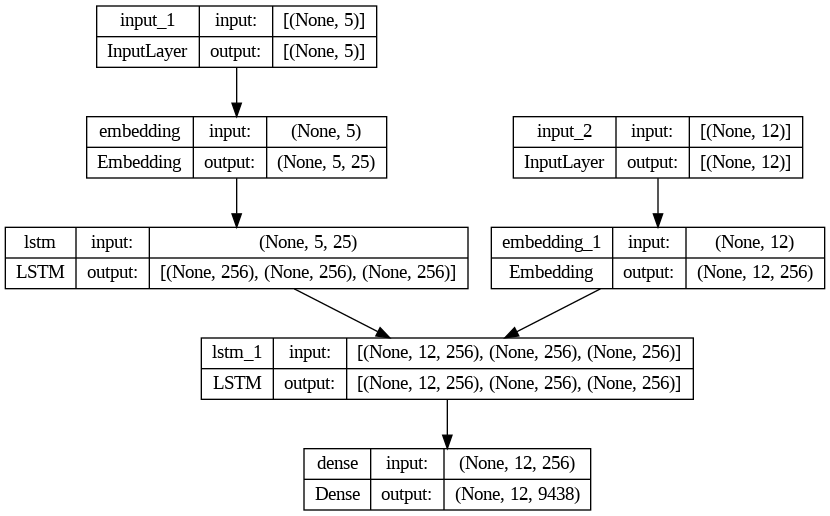

In [25]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

From the output, you can see that we have two types of input. input_1 is the input placeholder for the encoder, which is embedded and passed through lstm_1 layer, which basically is the encoder LSTM. There are three outputs from the lstm_1 layer: the output, the hidden layer and the cell state. However, only the cell state and the hidden state are passed to the decoder.

Here the lstm_2 layer is the decoder LSTM. The input_2 contains the output sentences with <sos> token appended at the start. The input_2 is also passed through an embedding layer and is used as input to the decoder LSTM, lstm_2. Finally, the output from the decoder LSTM is passed through the dense layer to make predictions.

In [26]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit([encoder_input_sequences, decoder_input_sequences], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=20,
    callbacks=[es],
    validation_split=0.1,
)


In [ ]:
model.save('seq2seq_eng-fra.h1')

In [ ]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('seq2seq_eng-fra.h1')

In [ ]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [ ]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)


In [ ]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [ ]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

# Making Predictions


we want our output to be a sequence of words in the French language. To do so, we need to convert the integers back to words. We will create new dictionaries for both inputs and outputs where the keys will be the integers and the corresponding values will be the words.

In [ ]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

The method will accept an input-padded sequence English sentence (in the integer form) and will return the translated French sentence.

In [ ]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])
print('Actual translation : ', output_sentences[i])
print('French translation : ', translation)